# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import img_to_array
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage import color, exposure
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import SpecificityAtSensitivity, AUC, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import layers, models, optimizers, datasets, utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# Required variable Initilizations

In [2]:
label_encoder = LabelEncoder()

train_dataset_path = './dataset/train'
test_dataset_path = './dataset/test'
validation_dataset_path = './dataset/validation'
normal_dataset_path = './dataset/entire_dataset/normal'
oscc_dataset_path = './dataset/entire_dataset/oscc'

image_size = 64

image_normalization_value = 255.0

dataset_paths = [train_dataset_path, test_dataset_path, validation_dataset_path]
class_categories = ['normal', 'oscc']

deep_neural_network_results = dict()
machine_learning_results = dict()

In [3]:
def load_images_by_folder_path(folder_path):
    image_data = []
    image_labels = []
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue
        for image_name in os.listdir(class_folder):
            loaded_image = cv2.imread(os.path.join(class_folder, image_name))
            if loaded_image is not None:
                resized_image = cv2.resize(loaded_image, (64, 64))
                image_data.append(resized_image)
                image_labels.append(label)
    return np.array(image_data), np.array(image_labels)


In [4]:
train_images, train_image_labels = load_images_by_folder_path(train_dataset_path)

train_labels_encoded = label_encoder.fit_transform(train_image_labels)
train_image_lables = to_categorical(train_labels_encoded)

train_images_normalized = train_images / image_normalization_value

In [5]:
test_images, test_image_labels = load_images_by_folder_path(test_dataset_path)

test_labels_encoded = label_encoder.fit_transform(test_image_labels)
test_image_lables = to_categorical(test_labels_encoded)

test_images_normalized = test_images / image_normalization_value

In [6]:
val_images, val_image_labels = load_images_by_folder_path(validation_dataset_path)

val_labels_encoded = label_encoder.fit_transform(val_image_labels)
val_image_lables = to_categorical(val_labels_encoded)

val_images_normalized = val_images / image_normalization_value

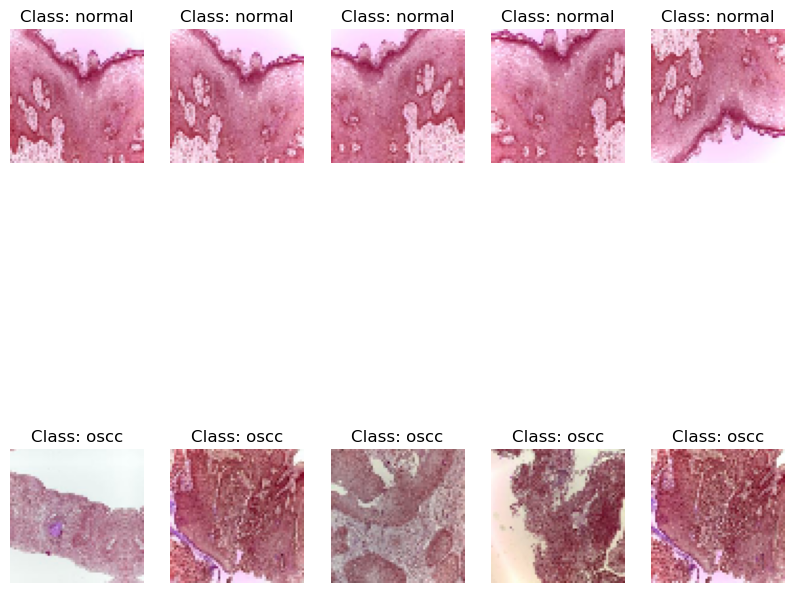

In [7]:
def render_images(images_data, image_labels, class_categories, image_count=5):
    plt.figure(figsize=(10, 10))
    for category in class_categories:
        index = [i for i, label in enumerate(image_labels) if label == category]
        for i, idx in enumerate(index[:image_count]):
            plt.subplot(len(class_categories), image_count, class_categories.index(category) * image_count + i + 1)
            plt.imshow(images_data[idx])
            plt.title(f'Class: {category}')
            plt.axis('off')
    plt.show()

render_images(train_images, train_image_labels, class_categories)

# **Combining all train, test and validation datasets into one**

In [4]:
def load_images_from_folder(source_folders, file_names, is_grayscale = False):
    images = []
    labels = []
    for file_name in file_names:
        for folder in source_folders:
            #for label in os.listdir(folder):
            class_folder = os.path.join(folder, file_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                img = cv2.imread(os.path.join(class_folder, filename))
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    if is_grayscale:
                        images.append(img_to_array(img_gray))
                    else:
                        images.append(img_to_array(img))
                    labels.append(file_name)
    return np.array(images), np.array(labels)

my_image_data = load_images_from_folder(dataset_paths, class_categories, is_grayscale = False)


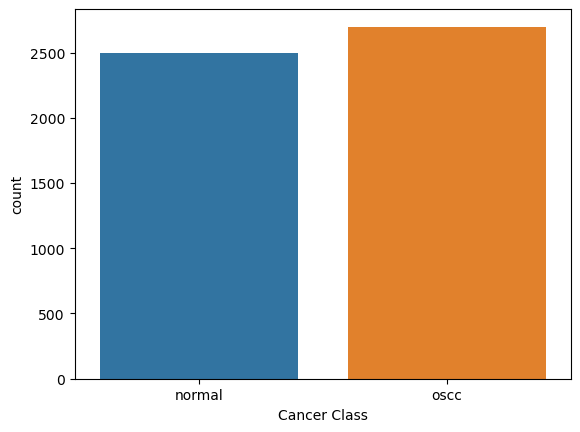

In [9]:
df = pd.DataFrame({'Cancer Class': my_image_data[1]})
sns.countplot(x='Cancer Class', data=df)
plt.show()

In [5]:
label_encoder = LabelEncoder()
image_labels_encoded = label_encoder.fit_transform(my_image_data[1])
categorical_labels = to_categorical(image_labels_encoded, num_classes=2)

image_data = my_image_data[0]
X_train_with_val, X_test, y_train_with_val, y_test = train_test_split(image_data, categorical_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_with_val, y_train_with_val, test_size=0.25, random_state=42)

# **CNN**

In [68]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 35]
}

results = {}

In [ ]:
highest_accuracy = 0
CNN_classes = []
CNN_pred_classes = []

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train.flatten())
class_weights_dict = dict(enumerate(class_weights))

for epochs in param_grid['epochs']:
    for optimizer in param_grid['optimizer']:
        for batch_size in param_grid['batch_size']:
                    
            model = Sequential([
                Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Dropout(0.25),

                Conv2D(128, (3, 3), padding='same', activation='relu'),
                Conv2D(128, (3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Dropout(0.25),

                Conv2D(256, (3, 3), padding='same', activation='relu'),
                Conv2D(256, (3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),
                Dropout(0.25),

                Flatten(),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(units=2, activation='softmax')
            ])

            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
            model.summary()

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)


            # Data augmentation
            train_datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                rescale = 1/255
            )

            train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
            # val_generator = train_datagen.flow(val_images_normalized, val_image_lables, batch_size=32)

            # Train the model with data augmentation
            history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping, reduce_lr], class_weight=class_weights_dict)

            # Evaluate the model
            
            
            config = f'epochs={epochs}, optimizer={optimizer}, batch_size={batch_size}'

            print(config)
            
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_test, axis=1)
            # class_labels = list(test_generator.class_indices.keys())

            # Generate classification report
            report = classification_report(y_true, y_pred_classes)
            print(report)

            report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
            if report_dict['accuracy'] > highest_accuracy:
                CNN_classes = y_true
                CNN_pred_classes = y_pred_classes
                highest_accuracy = report_dict['accuracy']
                deep_neural_network_results['CNN'] = report_dict['accuracy']


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 29, 29, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,846,210 (22.30 MB)

 Trainable params: 5,846,210 (22.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 541ms/step - accuracy: 0.5091 - loss: 0.6976 - val_accuracy: 0.5515 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 510ms/step - accuracy: 0.5282 - loss: 0.6925 - val_accuracy: 0.5515 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 497ms/step - accuracy: 0.5190 - loss: 0.6925 - val_accuracy: 0.5515 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.5054 - loss: 0.6933 - val_accuracy: 0.5515 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 509ms/step - accuracy: 0.5133 - loss: 0.6928 - val_accuracy: 0.5515 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 518ms/step - accuracy: 0.5153 - loss: 0.6928 - val_accuracy: 0.5515 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 505ms/step - accuracy:

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 29, 29, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,846,210 (22.30 MB)

 Trainable params: 5,846,210 (22.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4745 - loss: 0.7144 - val_accuracy: 0.4485 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5153 - loss: 0.6930 - val_accuracy: 0.4485 - val_loss: 5.2559 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5166 - loss: 0.6925 - val_accuracy: 0.4485 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5145 - loss: 0.6929 - val_accuracy: 0.4485 - val_loss: 1.0266 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5127 - loss: 0.6928 - val_accuracy: 0.4485 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5013 - loss: 0.6935 - val_accuracy: 0.4485 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.5187 - loss: 0.6927 - val_acc

In [41]:
# Calculate accuracy
accuracy = accuracy_score(CNN_classes, CNN_pred_classes)

# Calculate precision
precision = precision_score(CNN_classes, CNN_pred_classes)

# Calculate recall
recall = recall_score(CNN_classes, CNN_pred_classes)

# Calculate F1 score
f1 = f1_score(CNN_classes, CNN_pred_classes)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.55
Precision: 0.53
Recall: 0.86
F1 Score: 0.66


# Dense Net

In [29]:
# image_data_color = load_images_from_folder(dataset_paths, class_categories, is_grayscale=False)

# image_labels_encoded = label_encoder.fit_transform(image_data_color[1])
# categorical_labels = to_categorical(image_labels_encoded, num_classes=2)

# X_train_with_val, X_test, y_train_with_val, y_test = train_test_split(image_data_color[0] , categorical_labels, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_with_val, y_train_with_val, test_size=0.25, random_state=42)

In [11]:
DenseNet = tf.keras.applications.DenseNet121(include_top=False, 
                              weights='imagenet', 
                              input_shape=(64, 64, 3))

dense_model = Sequential([
    DenseNet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

dense_model.summary()


dense_model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

densenet_history = dense_model.fit(X_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_val, y_val))

test_loss, test_acc = dense_model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.6767 - loss: 0.8411 - val_accuracy: 0.5467 - val_loss: 3.1800
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8853 - loss: 0.2845 - val_accuracy: 0.6141 - val_loss: 1.7014
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9279 - loss: 0.1902 - val_accuracy: 0.6978 - val_loss: 1.5589
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9464 - loss: 0.1392 - val_accuracy: 0.6949 - val_loss: 1.1536
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9606 - loss: 0.1159 - val_accuracy: 0.8268 - val_loss: 0.6965
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9635 - loss: 0.0999 - val_accuracy: 0.8518 - val_loss: 0.5678
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9704 - loss: 0.0803 - val_accuracy: 0.8479 - val_loss: 0.6510
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9715 - loss: 0.0884 - val_accuracy: 0.8624 - val_loss

In [12]:
densenet_prediction_result = dense_model.predict(X_test)
densenet_predicted_classes = np.argmax(densenet_prediction_result, axis=1)
densenet_classes = np.argmax(y_test, axis=1)
# class_labels = list(test_generator.class_indices.keys())

# Generate classification report
densenet_report = classification_report(densenet_classes, densenet_predicted_classes)
print(densenet_report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 586ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       513
           1       0.88      0.91      0.90       526

    accuracy                           0.89      1039
   macro avg       0.89      0.89      0.89      1039
weighted avg       0.89      0.89      0.89      1039



In [13]:
densenet_report_dict = classification_report(densenet_classes, densenet_predicted_classes, output_dict=True)
deep_neural_network_results['Dense Net'] = densenet_report_dict['accuracy']

In [14]:
# Calculate accuracy
accuracy = accuracy_score(densenet_classes, densenet_predicted_classes)

# Calculate precision
precision = precision_score(densenet_classes, densenet_predicted_classes)

# Calculate recall
recall = recall_score(densenet_classes, densenet_predicted_classes)

# Calculate F1 score
f1 = f1_score(densenet_classes, densenet_predicted_classes)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.89
Precision: 0.88
Recall: 0.91
F1 Score: 0.90


# Efficient Net

In [15]:
efficientnet = EfficientNetB0(include_top=False, 
                              weights='imagenet', 
                              input_shape=(64, 64, 3))

# Add custom layers on top of the pre-trained EfficientNet model
efficientnet_model = Sequential([
    efficientnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Display the model's architecture
efficientnet_model.summary()


efficientnet_model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(X_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_val, y_val))

test_loss, test_acc = efficientnet_model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7025 - loss: 0.6233 - val_accuracy: 0.5679 - val_loss: 0.9092
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9095 - loss: 0.2115 - val_accuracy: 0.7690 - val_loss: 0.7147
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9586 - loss: 0.1068 - val_accuracy: 0.7931 - val_loss: 0.7650
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9737 - loss: 0.0735 - val_accuracy: 0.8325 - val_loss: 0.7124
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9718 - loss: 0.0824 - val_accuracy: 0.8884 - val_loss: 0.5647
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9742 - loss: 0.0630 - val_accuracy: 0.9192 - val_loss: 0.3867
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9849 - loss: 0.0460 - val_accuracy: 0.9124 - val_loss: 0.3850
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9826 - loss: 0.0479 - val_accuracy: 0.9355 - val_loss

In [16]:
efficientnet_prediction_result = efficientnet_model.predict(X_test)
efficientnet_predicted_classes = np.argmax(efficientnet_prediction_result, axis=1)
efficientnet_classes = np.argmax(y_test, axis=1)

efficientnet_report = classification_report(efficientnet_classes, efficientnet_predicted_classes)
print(efficientnet_report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       513
           1       0.92      0.92      0.92       526

    accuracy                           0.92      1039
   macro avg       0.92      0.92      0.92      1039
weighted avg       0.92      0.92      0.92      1039



In [17]:
efficientnet_report_dict = classification_report(efficientnet_classes, efficientnet_predicted_classes, output_dict=True)
deep_neural_network_results['Efficient Net'] = efficientnet_report_dict['accuracy']

In [18]:
# Calculate accuracy
accuracy = accuracy_score(efficientnet_classes, efficientnet_predicted_classes)

# Calculate precision
precision = precision_score(efficientnet_classes, efficientnet_predicted_classes)

# Calculate recall
recall = recall_score(efficientnet_classes, efficientnet_predicted_classes)

# Calculate F1 score
f1 = f1_score(efficientnet_classes, efficientnet_predicted_classes)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


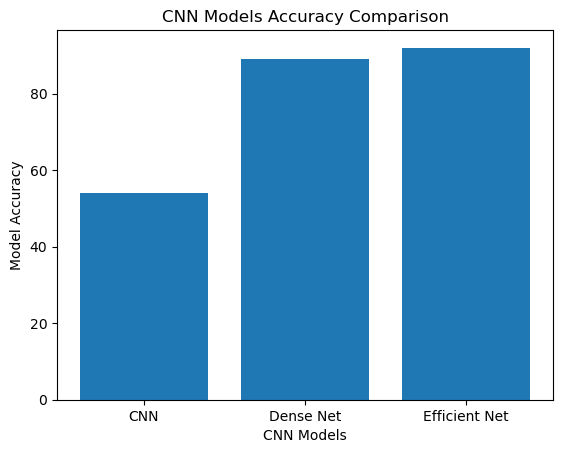

In [21]:
cnn_model_names = list(deep_neural_network_results.keys())
cnn_model_accuracies = list(deep_neural_network_results.values())

# Plotting the bar chart
plt.bar(cnn_model_names, cnn_model_accuracies)

# Adding labels and title
plt.xlabel('CNN Models')
plt.ylabel('Model Accuracy')
plt.title('CNN Models Accuracy Comparison')

# Show the plot
plt.show()

# **Machine Learning Models**

## Feature extraction using HOG

In [7]:
def extract_features(images):
    feature_list = []
    for img in images:
        # Example with HOG features
        features, hog_image = hog(img, channel_axis=2, visualize=True, feature_vector=True)
        feature_list.append(features)
    return feature_list

features = extract_features(image_data)

In [8]:
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(features, image_labels_encoded, test_size=0.2, random_state=42)

# **SVM**

In [21]:
svc_tuning_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 1],
    'kernel': ['linear', 'rbf']
}

In [22]:
svc_model = SVC()
svc_grid_search = GridSearchCV(svc_model, svc_tuning_params, refit=True, verbose=2)

svc_grid_search.fit(X_train_hog, y_train_hog)

# Predict and evaluate
svc_prediction = svc_grid_search.predict(X_test_hog)

svc_report_dict = classification_report(y_test_hog, svc_prediction, target_names=label_encoder.classes_, output_dict=True)
print(svc_report_dict)
machine_learning_results['svc'] = svc_report_dict['accuracy']

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  29.9s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  25.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  31.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  30.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  31.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  29.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  34.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  23.5s
[CV] END ...................C=0.1, gamma=0.01, k

In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test_hog, svc_prediction)

# Calculate precision
precision = precision_score(y_test_hog, svc_prediction)

# Calculate recall
recall = recall_score(y_test_hog, svc_prediction)

# Calculate F1 score
f1 = f1_score(y_test_hog, svc_prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.73
Precision: 0.73
Recall: 0.76
F1 Score: 0.74


# **RandomForest Classifier**

In [9]:
random_forest_tuning_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 20],
    'bootstrap': [True, False]
}

In [10]:
random_forest_model = RandomForestClassifier(random_state=42)

random_forest_grid_search = GridSearchCV(random_forest_model, random_forest_tuning_params,cv=5, n_jobs=-1, verbose=2)

random_forest_grid_search.fit(X_train_hog, y_train_hog)

# Predict and evaluate
random_forest_prediction = random_forest_grid_search.predict(X_test_hog)
random_forest_report = classification_report(y_test_hog, random_forest_prediction, target_names=label_encoder.classes_)
print("Classification Report:\n", random_forest_report)

random_forest_report_dict = classification_report(y_test_hog, random_forest_prediction, target_names=label_encoder.classes_, output_dict=True)
machine_learning_results['random_forest'] = random_forest_report_dict['accuracy']

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Classification Report:
               precision    recall  f1-score   support

      normal       0.69      0.60      0.65       513
        oscc       0.66      0.74      0.70       526

    accuracy                           0.67      1039
   macro avg       0.68      0.67      0.67      1039
weighted avg       0.68      0.67      0.67      1039



In [11]:
random_forest_report_dict = classification_report(y_test_hog, random_forest_prediction, target_names=label_encoder.classes_, output_dict=True)
machine_learning_results['random_forest'] = random_forest_report_dict['accuracy']

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test_hog, random_forest_prediction)

# Calculate precision
precision = precision_score(y_test_hog, random_forest_prediction)

# Calculate recall
recall = recall_score(y_test_hog, random_forest_prediction)

# Calculate F1 score
f1 = f1_score(y_test_hog, random_forest_prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.67
Precision: 0.66
Recall: 0.74
F1 Score: 0.70


# **Decision Tree**

In [13]:
decision_tree_tuning_params = {
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6], 
    'max_depth': [10, 20, 30],
}

In [14]:
decision_tree_model = DecisionTreeClassifier(random_state=42)

decision_tree_grid_search = GridSearchCV(estimator=decision_tree_model, param_grid=decision_tree_tuning_params, 
                           cv=5, n_jobs=-1, verbose=2)
decision_tree_grid_search.fit(X_train_hog, y_train_hog)

# Predict and evaluate
decision_tree_prediction = decision_tree_grid_search.predict(X_test_hog)

decision_tree_report = classification_report(y_test_hog, decision_tree_prediction, target_names=label_encoder.classes_)
print("Classification Report:\n", decision_tree_report)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classification Report:
               precision    recall  f1-score   support

      normal       0.53      0.50      0.52       513
        oscc       0.54      0.57      0.56       526

    accuracy                           0.54      1039
   macro avg       0.54      0.54      0.54      1039
weighted avg       0.54      0.54      0.54      1039



In [15]:
decision_tree_report_dict = classification_report(y_test_hog, decision_tree_prediction, target_names=label_encoder.classes_, output_dict=True)
machine_learning_results['decision_tree'] = decision_tree_report_dict['accuracy']

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test_hog, decision_tree_prediction)

# Calculate precision
precision = precision_score(y_test_hog, decision_tree_prediction)

# Calculate recall
recall = recall_score(y_test_hog, decision_tree_prediction)

# Calculate F1 score
f1 = f1_score(y_test_hog, decision_tree_prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.54
Precision: 0.54
Recall: 0.57
F1 Score: 0.56


## Machine model results comparison

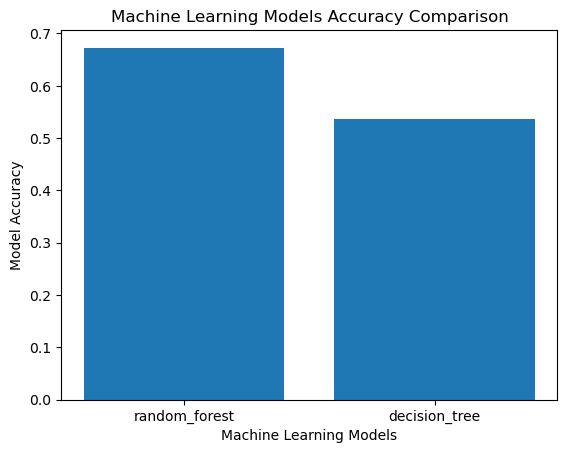

In [17]:
model_names = list(machine_learning_results.keys())
model_accuracies = list(machine_learning_results.values())

# Plotting the bar chart
plt.bar(model_names, model_accuracies)

# Adding labels and title
plt.xlabel('Machine Learning Models')
plt.ylabel('Model Accuracy')
plt.title('Machine Learning Models Accuracy Comparison')

# Show the plot
plt.show()